### 규제화(regularization)
- RSS를 최소화하는 과정에서 축소 벌점(shrinkage penalty)를 적용하는 것
- 벌점은 베타 계수와 가중합을 정규화한 값과 람다로 이루어진다.
- 규제화를 사용하면 편향-분산 트레이드 오프를 최적화해 모형이 가장 적합하도록 개선할 수 있다. 또한 다중 공선성 문제를 해결할 수 있다.

#### 능형회귀분석
[LASSO]
- L1-norm(변수 가중치의 절대값의 합)을 사용한다.
- 어떤 변수의 가중값을 0으로 만들 수 있다.
- 공선성이 높은 경우 변수 중 하나에 관련된 계수를 0으로 만들어버려 예측 능력을 상실 할 수 있다.

[일레스틱넷]
- L1-norm과 L2-norm을 섞어서 사용한다.

In [1]:
STORAGE = strsplit(Sys.getenv("STORAGE"),",")[[1]] # 데이터 저장 위치
DATA_DIR = paste(STORAGE,"/Structured/R/data", sep="")

### Prostate
- 전립선 절제 수술을 받을 남자들에 대해 전립선 특이항원 수준과 임상 측정치의 상관관계를 조사

[변수 설명]
- lcavol : 암 부피의 log값
- lweight : 전립선의 무게 log값
- age : 환자의 나이
- lbph : 전립선 비대 크기의 log값
- svi : 정남 침범, 암 세포가 전립선 바깥에 있는 정낭에 침범했는지 여부(1=예, 0=아니오)
- lcp : 암 세포가 전립선 표면에 얼마나 확장했고, 내부로 얼마나 침투했는지 나타내는 log값
- gleason : 환자의 글리슨 점수.병리학자가 매긴 점수(2~10)로 높을수록 공격적인 암
- pgg45 : 글리슨 점수 4또는 5의 비율
- lpsa : PSA의 log값(목표 변수)
- train : 학습/평가를 구분하는 값

In [2]:
library(car) # 분산 팽창 인수
library(corrplot) # 상관관계를 도표로 시각화
library(leaps) # 최량 부분 집합 회귀
library(glmnet) # 능형회귀분석과 LASSO, 일레스틱넷
library(caret) # 매개변수 조정
library(lmtest) # 이분산성 white test

load(paste(DATA_DIR,"/prostate.RData", sep="")) # 데이터 읽기

Loading required package: carData

corrplot 0.92 loaded

Loading required package: Matrix

Loaded glmnet 4.1-8

Loading required package: ggplot2

Loading required package: lattice



## 데이터 확인

In [3]:
str(prostate)

'data.frame':	97 obs. of  10 variables:
 $ lcavol : num  -0.58 -0.994 -0.511 -1.204 0.751 ...
 $ lweight: num  2.77 3.32 2.69 3.28 3.43 ...
 $ age    : int  50 58 74 58 62 50 64 58 47 63 ...
 $ lbph   : num  -1.39 -1.39 -1.39 -1.39 -1.39 ...
 $ svi    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ lcp    : num  -1.39 -1.39 -1.39 -1.39 -1.39 ...
 $ gleason: int  6 6 7 6 6 6 6 6 6 6 ...
 $ pgg45  : int  0 0 20 0 0 0 0 0 0 0 ...
 $ lpsa   : num  -0.431 -0.163 -0.163 -0.163 0.372 ...
 $ train  : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...


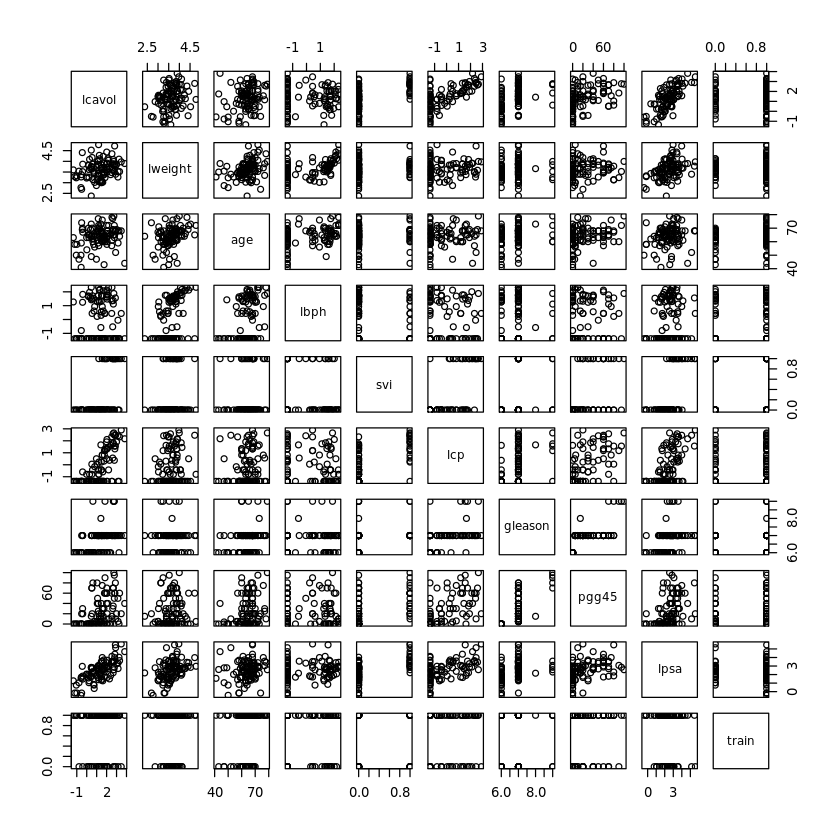

In [4]:
plot(prostate) # 산점도 행렬
# 모든 변수가 int 또는 logical이면 가능

- lpsa와 lcavol사이에는 선형관계가 있어 보인다.
- 각 변수들이 서로 특정한 모양이 없어 보인다.
- gleason의 경우 4개의 값만 존재하며 테스트 데이터의 경우 3개의 값만 가진다. 문제가 발생할 가능성이 있다.

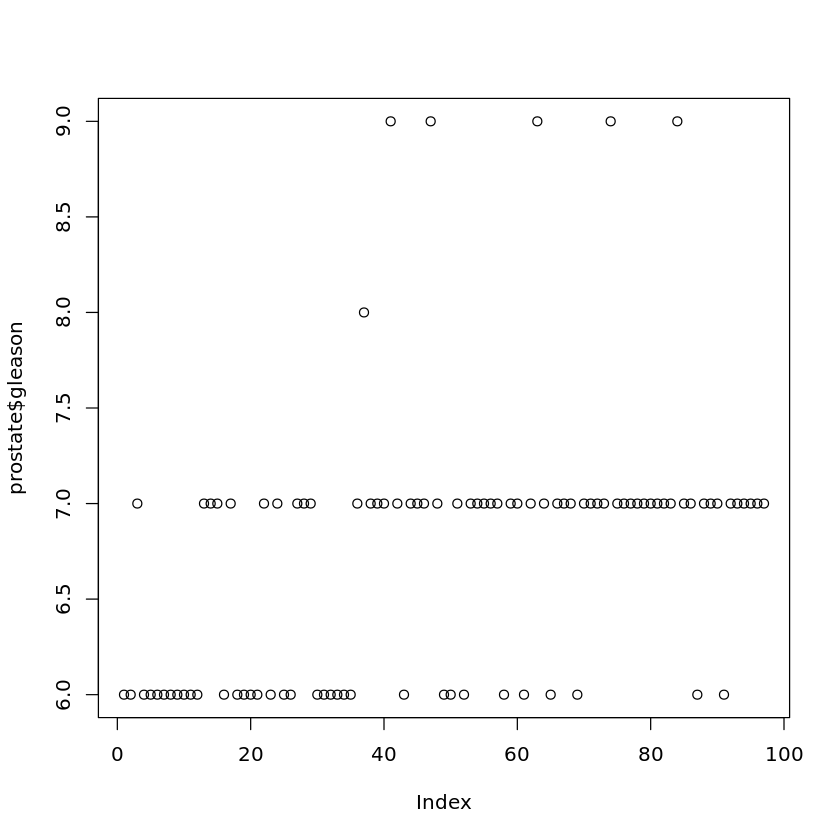

In [5]:
plot(prostate$gleason)

- 글리슨 점수가 8인 관측치가 1개 9인 관측치가 5개만 존재한다. -> 학습/평가시 문제가 발생한다.

[선택지]
- 이 변수를 분석에서 제외한다.
- 점수 8,9인 관측치들만 제외한다.
- 변수를 바꿔 지시변수로 만든다.

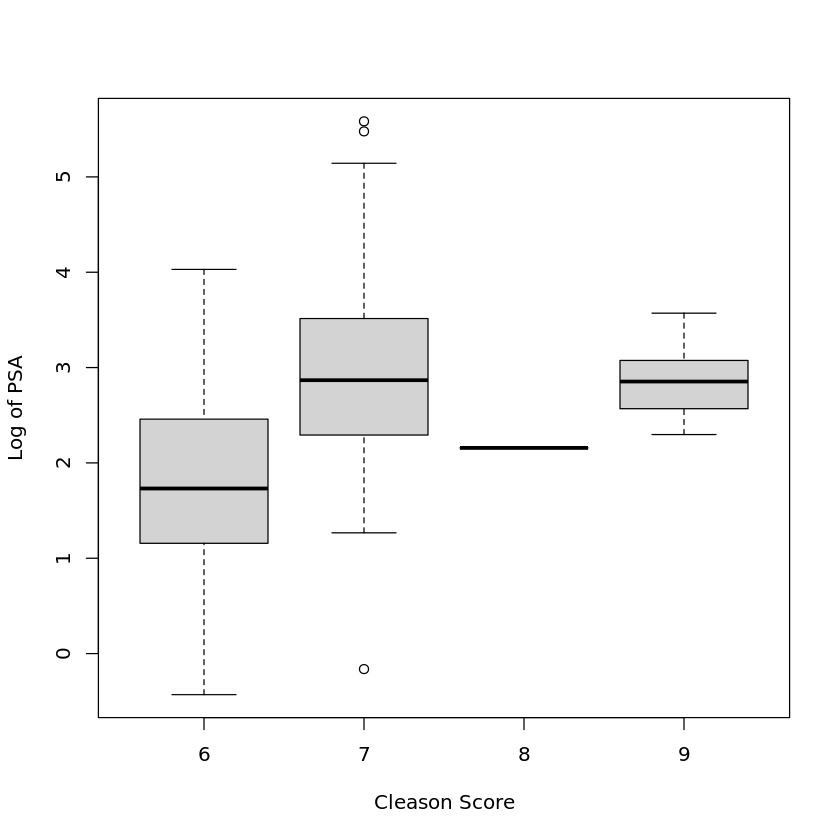

In [6]:
boxplot(prostate$lpsa ~ prostate$gleason, xlab="Cleason Score", ylab="Log of PSA")

- gleason을 제거하면 분석에 문제가 생길 가능성이 있다.
- 점수가 6일때 0, 7이상이면 1로 변환한다.

In [7]:
prostate$gleason <- ifelse(prostate$gleason >= 7, 1, 0)
str(prostate)

'data.frame':	97 obs. of  10 variables:
 $ lcavol : num  -0.58 -0.994 -0.511 -1.204 0.751 ...
 $ lweight: num  2.77 3.32 2.69 3.28 3.43 ...
 $ age    : int  50 58 74 58 62 50 64 58 47 63 ...
 $ lbph   : num  -1.39 -1.39 -1.39 -1.39 -1.39 ...
 $ svi    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ lcp    : num  -1.39 -1.39 -1.39 -1.39 -1.39 ...
 $ gleason: num  0 0 1 0 0 0 0 0 0 0 ...
 $ pgg45  : int  0 0 20 0 0 0 0 0 0 0 ...
 $ lpsa   : num  -0.431 -0.163 -0.163 -0.163 0.372 ...
 $ train  : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...


In [8]:
table(prostate$gleason)
# 0은 35개, 1은 62개


 0  1 
35 62 

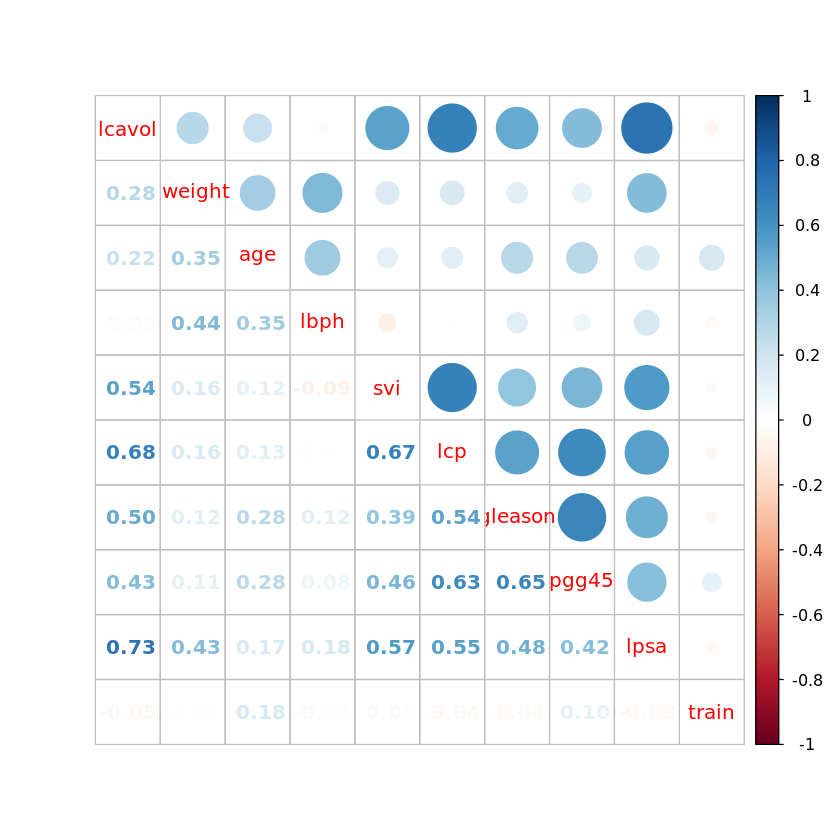

In [9]:
# 상관 도표
p.cor <- cor(prostate)
corrplot.mixed(p.cor)

- lcavol과 lpsa는 상관성이 높다.
- lcavol, lcp, svi, pgg45, gleason은 공선성 문제가 있을 가능성이 높다.

In [10]:
train <-subset(prostate, prostate$train)[,-ncol(prostate)]
test <-subset(prostate, !prostate$train)[,-ncol(prostate)]

## 모형화와 평가
### 최량 부분 집합

In [12]:
subfit <- regsubsets(lpsa ~ ., data=train)
b.sum <- summary(subfit)
which.min(b.sum$bic) # bic가 가장 작은 모형은 3개의 변수를 가진다.

[1] 3

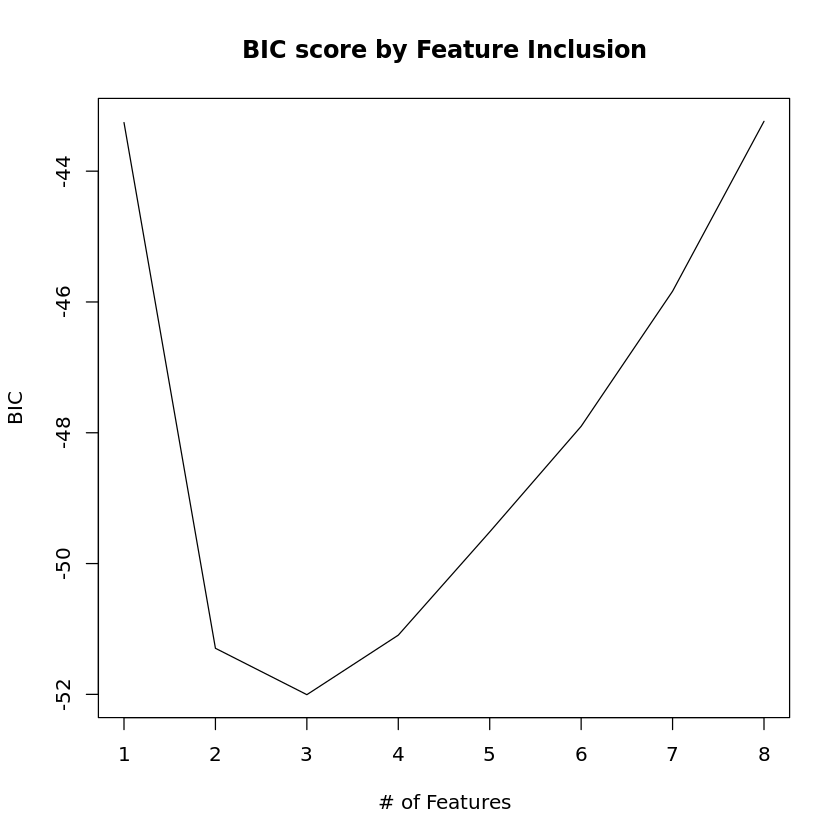

In [13]:
plot(b.sum$bic, type="l", xlab="# of Features", ylab="BIC", main="BIC score by Feature Inclusion")

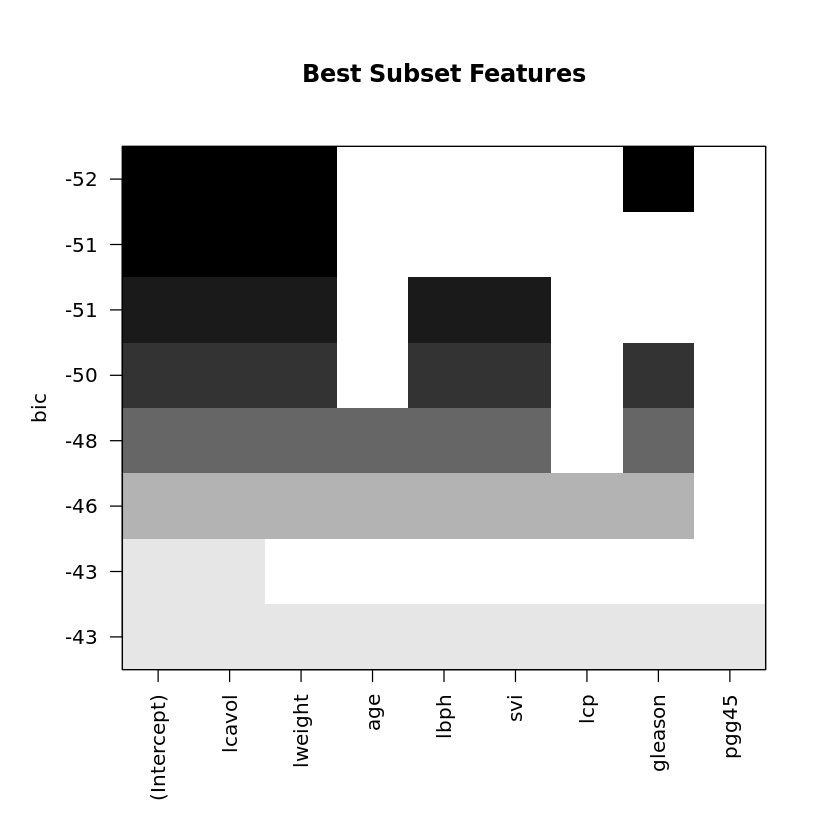

In [14]:
plot(subfit, sacle="bic", main="Best Subset Features")

- lcavol, lweight, gleason 변수를 사용한다.

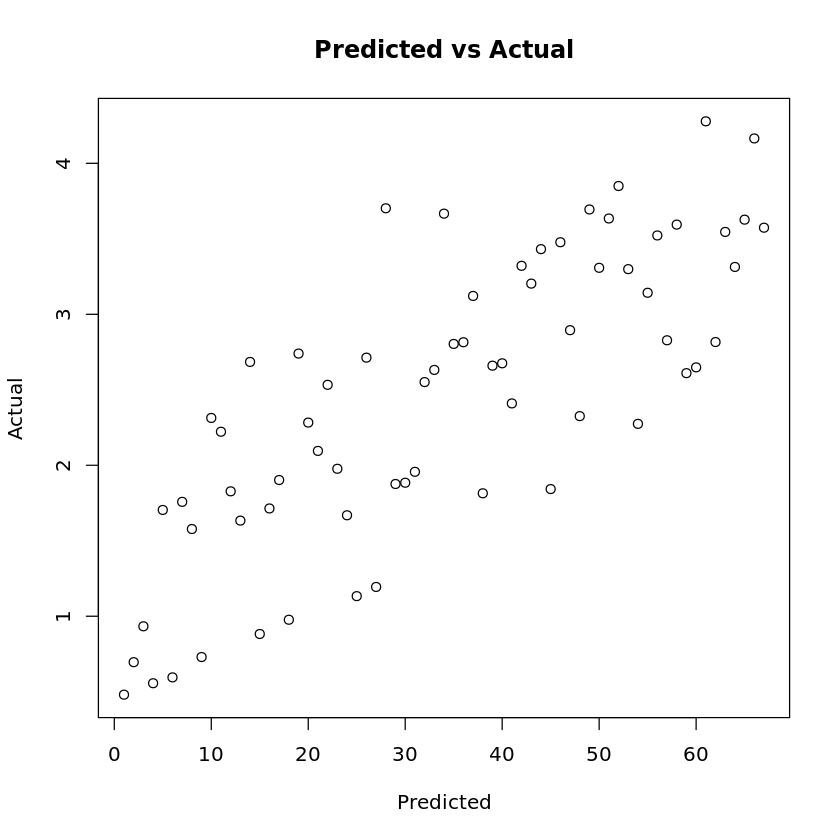

In [15]:
ols <- lm(lpsa ~ lcavol + lweight + gleason, data=train)
plot(ols$fitted.values, train$plsa, xlab="Predicted", ylab="Actual", main="Predicted vs Actual")

- 학습 데이터가 거의 선형을 예측된다.
- 분산이 일정하지 않다.

ERROR: Error in c(1, 1, ): argument 3 is empty


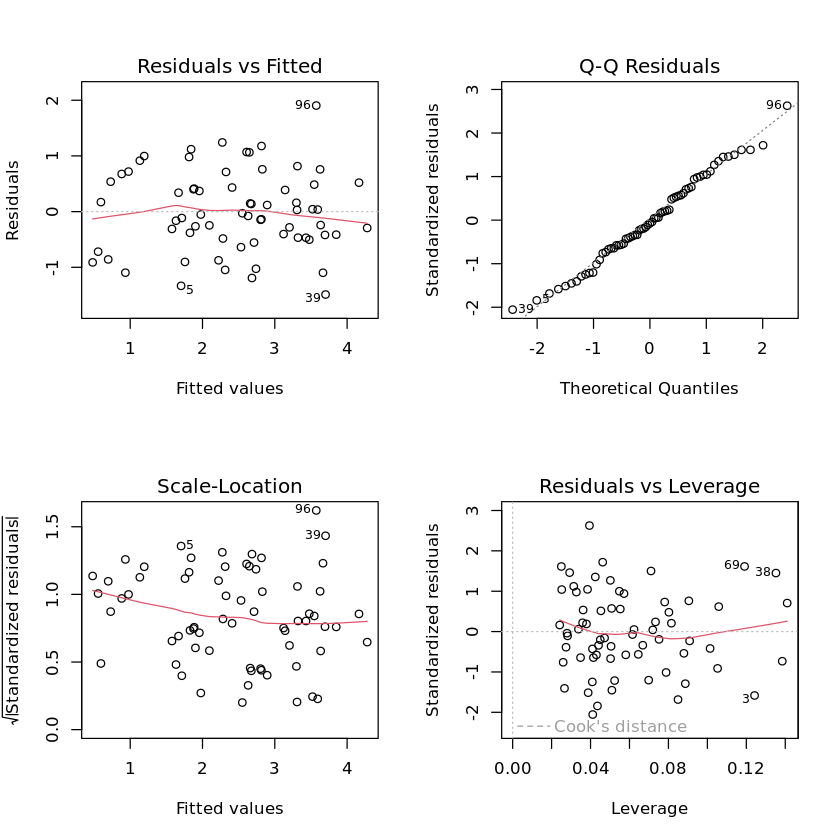

In [18]:
par(mfrow = c(2,2))
plot(ols)
par(mflow = c(1,1,))

- 잔차 분석에서 잔차가 특정 형태가 없으며 정규분포를 따르고 이상치로 예측되는 값이 없지만 분산이 일정하지 않은것으로 의심된다.

[등분산 해결 방법]
- Heteroskedastic Robust Standard error
    - 안정성과 이분산 문제의 해결책으로 인정받는 방법
    - 이분산을 모를 때 사용 가능
    - 계산 방법이 복잡하다.
    - white의 이분산이 교정된 표준오차가 robust 표준오차이다.
- Weight least square regression(WLS regression, 가중최소자승법)
    - 비례적 이분산성의 경우에 사용
    - 이분산성의 함수를 찾아 그 역함수로 독립변수를 만들어 추가하는 OLS 추정법
    - 회귀함수의 오차항을 각각의 분산으로 나누어준뒤 도출된 오차자승합을 최소화시킴으로 도출
    - 이분산성의 함수를 찾는것이 쉽지 않음
- GLS/FGLS regression(일반화된 최소자승법)
    - 고전적 모형의 가정을 만족시키기 위해 원래의 변수들을 변환하고 나서 OLS를 적용하는 절차
    - GLS와 FGLS 모두 근본적으로 WLS와 유사
    - GLS는 이분산을 알고 있을 때 사용
    - GLS는 잔차 제곱에 가중치를 곱한 합계를 극소화한다. 이때 이분산 제곱의 역수가 가중치 역할을 한다.

In [38]:
# 이분산 검증 white test
bptest(ols,  ~ lcavol*lweight*gleason + I(lcavol^2)+ I(lweight^2)+ I(gleason^2), data = train)
# bp test에 항을 추가하여 white test를 진행
# H0 : 등분산성을 만족한다.
# H1 : 등분산성을 만족하지 못한다.
# 결과 : p-value가 유의수준 0.01보다 크기 때문에 귀무가설(H0)를 기각하지 못한다. 따라서 등분산성을 만족한다.


	studentized Breusch-Pagan test

data:  ols
BP = 5.1031, df = 9, p-value = 0.8252


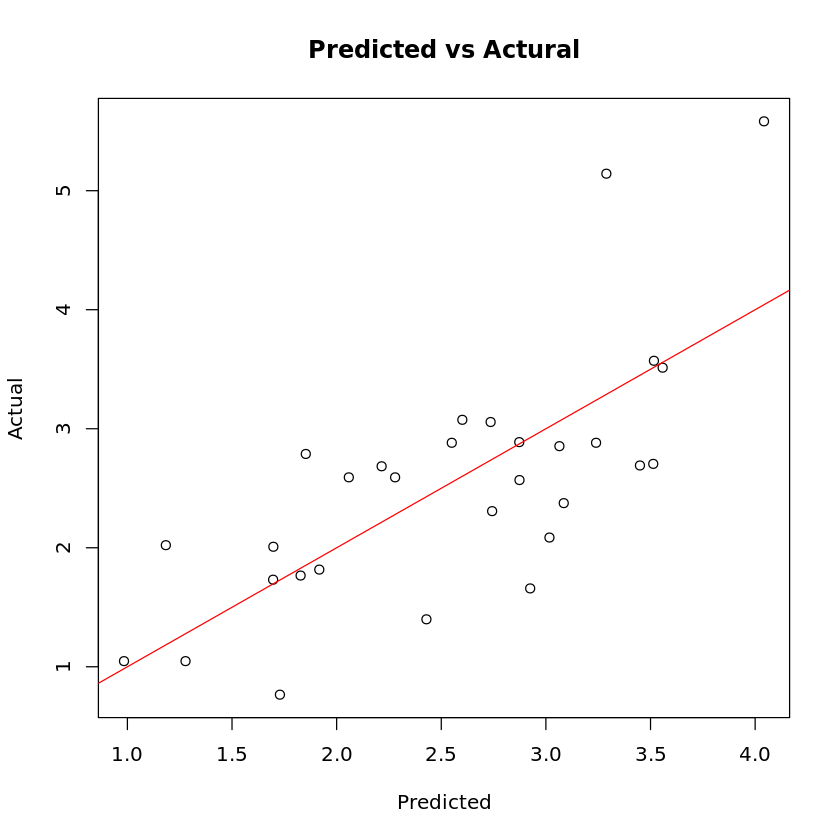

In [52]:
pred.subfit <- predict(ols, newdata=test)
plot(pred.subfit, test$lpsa, xlab="Predicted", ylab="Actual", main="Predicted vs Actural")
lines(0:6, 0:6, col="#FF0000")

- 대부분의 값이 직선위에 존재한다.
- 2개의 값이 차이가 크가.

In [56]:
# MSE 계산
resid.subfit <- test$lpsa - pred.subfit
mse = mean(resid.subfit^2)
cat(paste("MSE : ",mse, sep=""))

MSE : 0.508412616577747

### 능형 회귀 분석